<a href="https://colab.research.google.com/github/shashankag14/OpenPCDet/blob/DA-15-class-balance-imp/tb_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook fetches the TB logs from Tensorboard-Dev and recreates the plots with further smoothening.
All experiments will be present here - https://tensorboard.dev/experiments/

In [1]:

from packaging import version
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d 
import warnings
warnings.filterwarnings('ignore')

Fetch the values of the TB logs for a particular experiment using its experiment ID in tensorboard dev.

In [2]:
experiment_id = "wTqPAlH8QyqGCNxSVTOLpQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

Save the TB log values into excel (added this for any future purpose)

In [3]:
dfw = experiment.get_scalars(pivot=False) 
root_dir = os.getcwd()
csv_path = root_dir + '/tb_experiment_1.csv'
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

Fetch score_fgs of each class and apply 1D gaussian smoothening
TODO : Check approrpiate sigma for smoothening

In [4]:
dfw_score_fgs_car = dfw[dfw.run.str.contains("/score_fgs/Car")]
dfw_score_fgs_car["smooth_value"] = gaussian_filter1d(dfw_score_fgs_car["value"], sigma=3)

dfw_score_fgs_ped = dfw[dfw.run.str.contains("/score_fgs/Ped")]
dfw_score_fgs_ped["smooth_value"] = gaussian_filter1d(dfw_score_fgs_ped["value"], sigma=3)

dfw_score_fgs_cyc = dfw[dfw.run.str.contains("/score_fgs/Cyclist")]
dfw_score_fgs_cyc["smooth_value"] = gaussian_filter1d(dfw_score_fgs_cyc["value"], sigma=3)

 1) Interpolate values for each test iteration, 2. stretchen the curve by scaling up the x-range to match the range for train iterations, 3. then again interpolate for each train iteration.

In [5]:
# TODO : Values taken from TB logs, but work only when train batch size is 4 and test batch size is 8
max_train_tr = 2815 
max_test_itr = 469

# 1. Interpolate values for each test iteration
df_ip = pd.DataFrame()
df_ip["itr"] = np.arange(0, max_test_itr, 1)

df_ip["ip_score_fgs_car"] = np.interp(df_ip["itr"], dfw_score_fgs_car["step"], dfw_score_fgs_car["smooth_value"])
df_ip["ip_score_fgs_ped"] = np.interp(df_ip["itr"], dfw_score_fgs_ped["step"], dfw_score_fgs_ped["smooth_value"])
df_ip["ip_score_fgs_cyc"] = np.interp(df_ip["itr"], dfw_score_fgs_cyc["step"], dfw_score_fgs_cyc["smooth_value"])

# 2. stretchen the curve by scaling up the x-range to match the range for train iterations
df_ip["itr_"] = df_ip["itr"] * int(max_train_tr/max_test_itr)

# 3. then again interpolate for each train iteration
df_ip_train = pd.DataFrame()
df_ip_train["itr_train"] = np.arange(0, max_train_tr, 1)
df_ip_train["ip_score_fgs_car"] = np.interp(df_ip_train["itr_train"], df_ip["itr_"], df_ip["ip_score_fgs_car"])
df_ip_train["ip_score_fgs_ped"] = np.interp(df_ip_train["itr_train"], df_ip["itr_"], df_ip["ip_score_fgs_ped"])
df_ip_train["ip_score_fgs_cyc"] = np.interp(df_ip_train["itr_train"], df_ip["itr_"], df_ip["ip_score_fgs_cyc"])     

# Save pseudo train score fgs into an excel. This excel can be used in the model to choose the thresholds
root_dir = os.getcwd()
csv_path = root_dir + '/tb_pseudo_train_score_fgs.csv'
df_ip_train.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, df_ip_train)

Plots
1. Car

Text(0.5, 1.0, 'Pseudo Train smoothened score_fgs/Car')

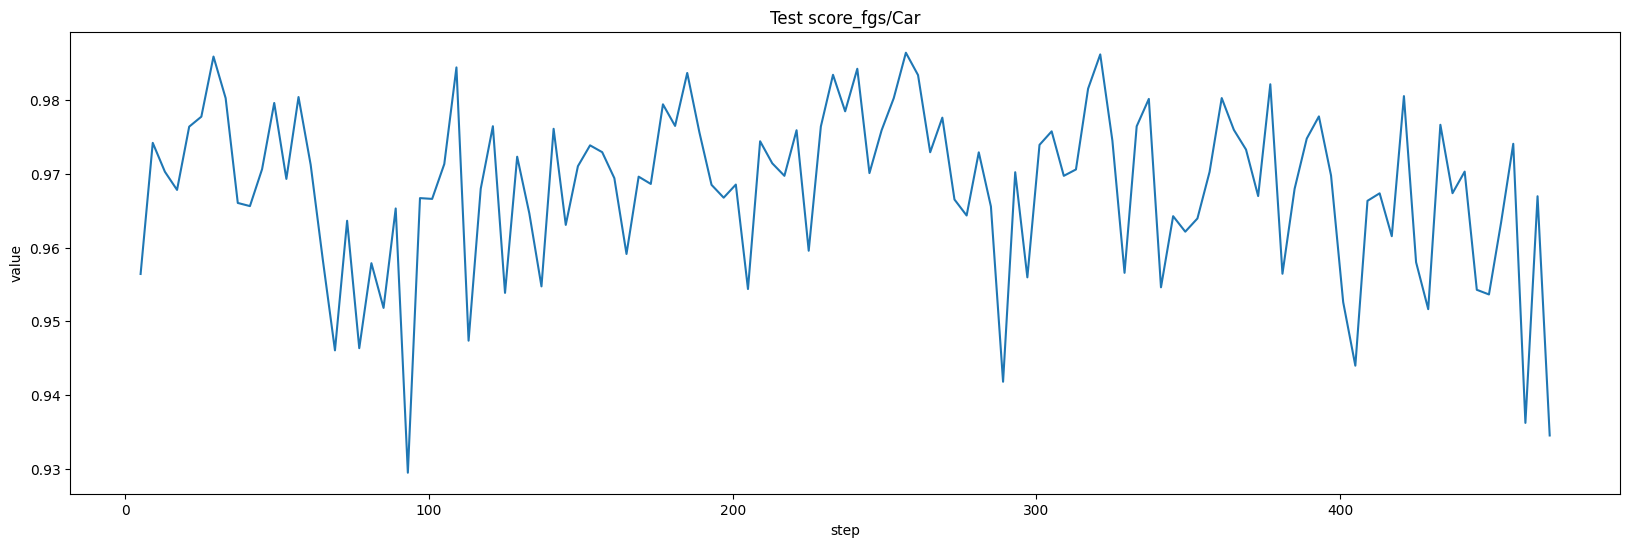

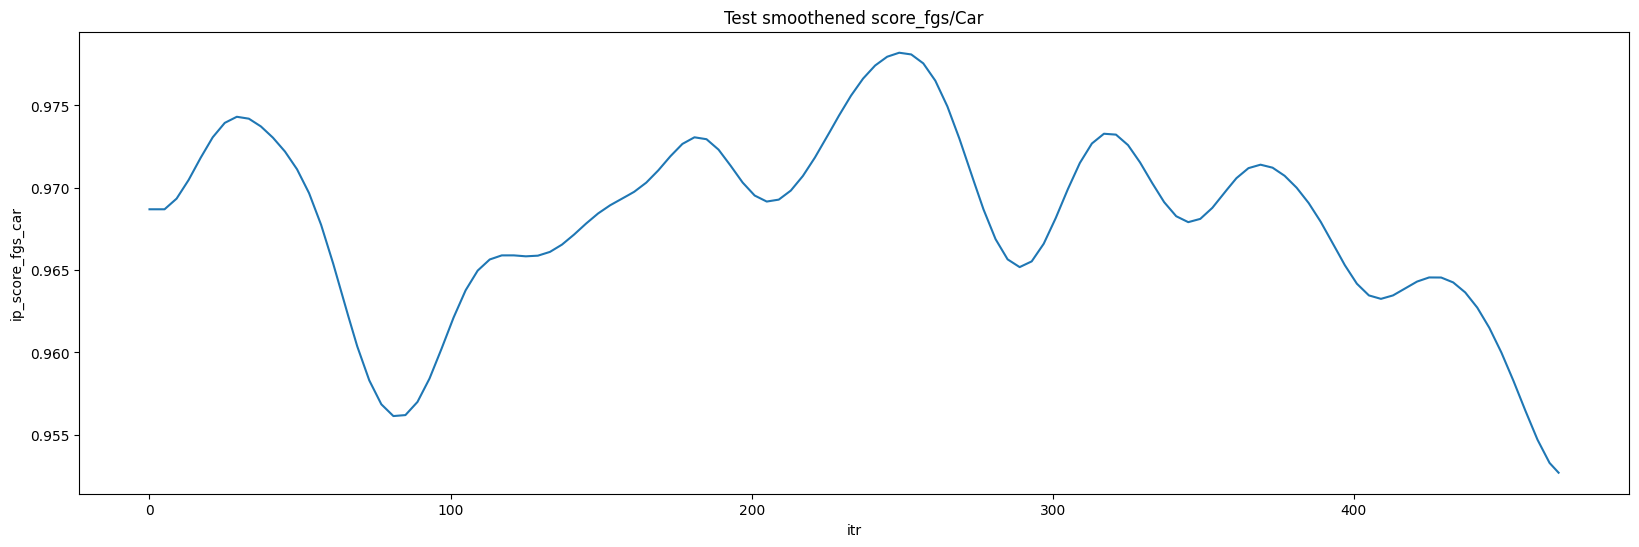

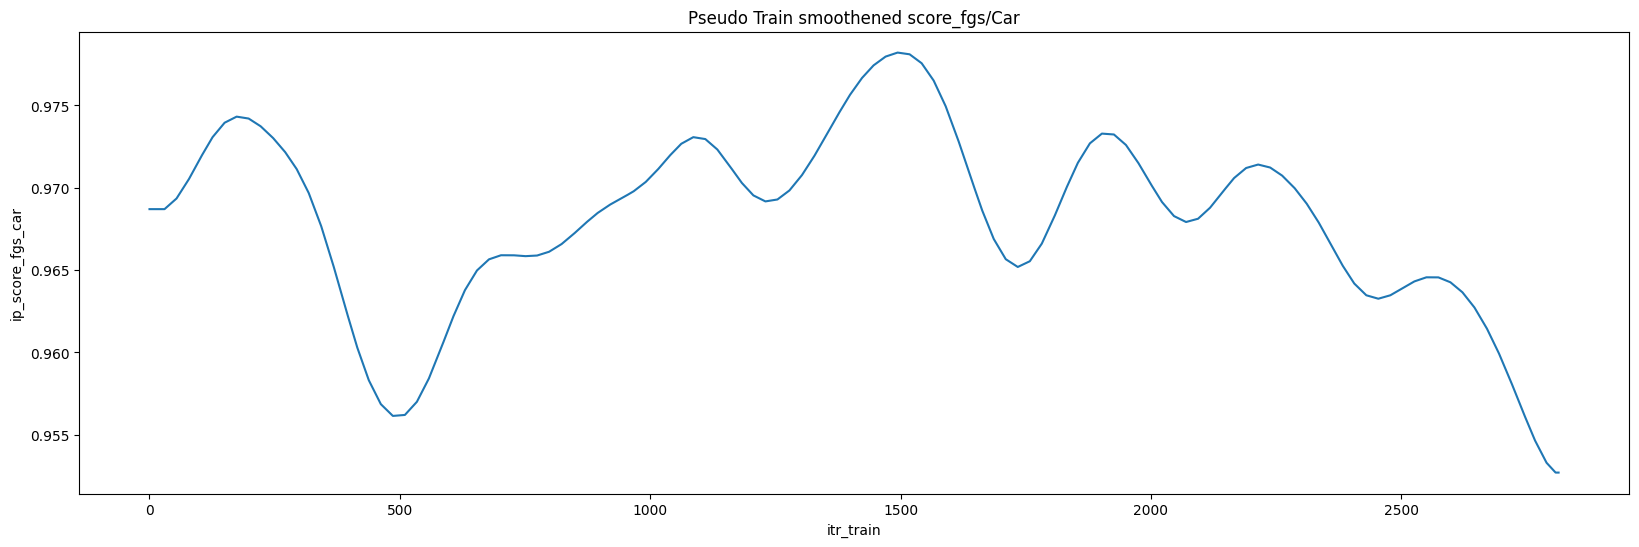

In [6]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=dfw_score_fgs_car, x="step", y="value",
             ).set_title("Test score_fgs/Car")

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip, x="itr", y="ip_score_fgs_car",
             ).set_title("Test smoothened score_fgs/Car")

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip_train, x="itr_train", y="ip_score_fgs_car",
             ).set_title("Pseudo Train smoothened score_fgs/Car")


2. Pedestrian

Text(0.5, 1.0, 'Pseudo Train score_fgs/Ped')

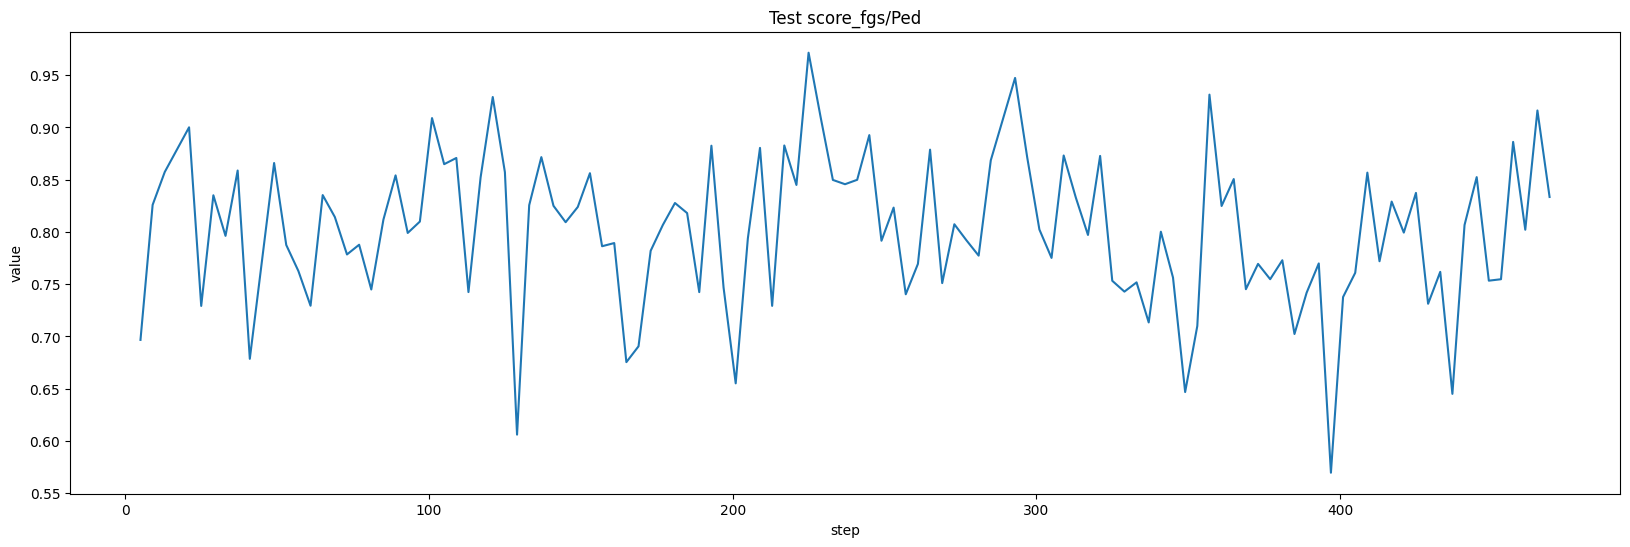

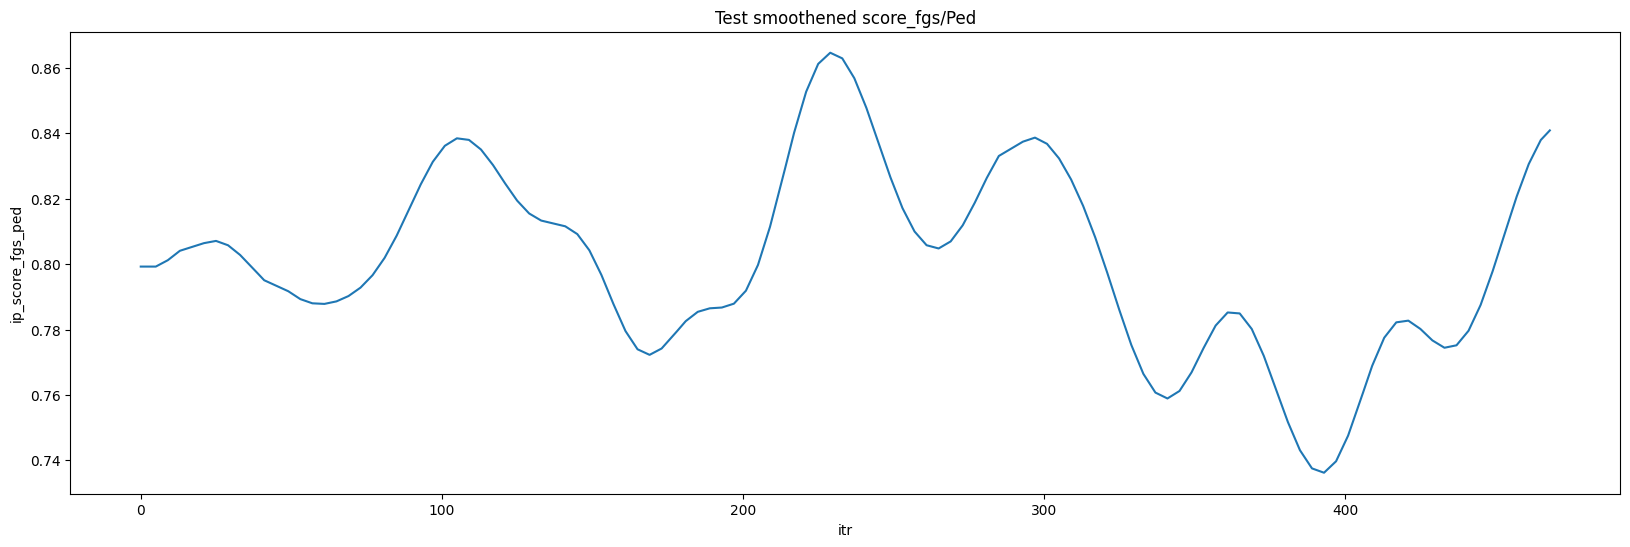

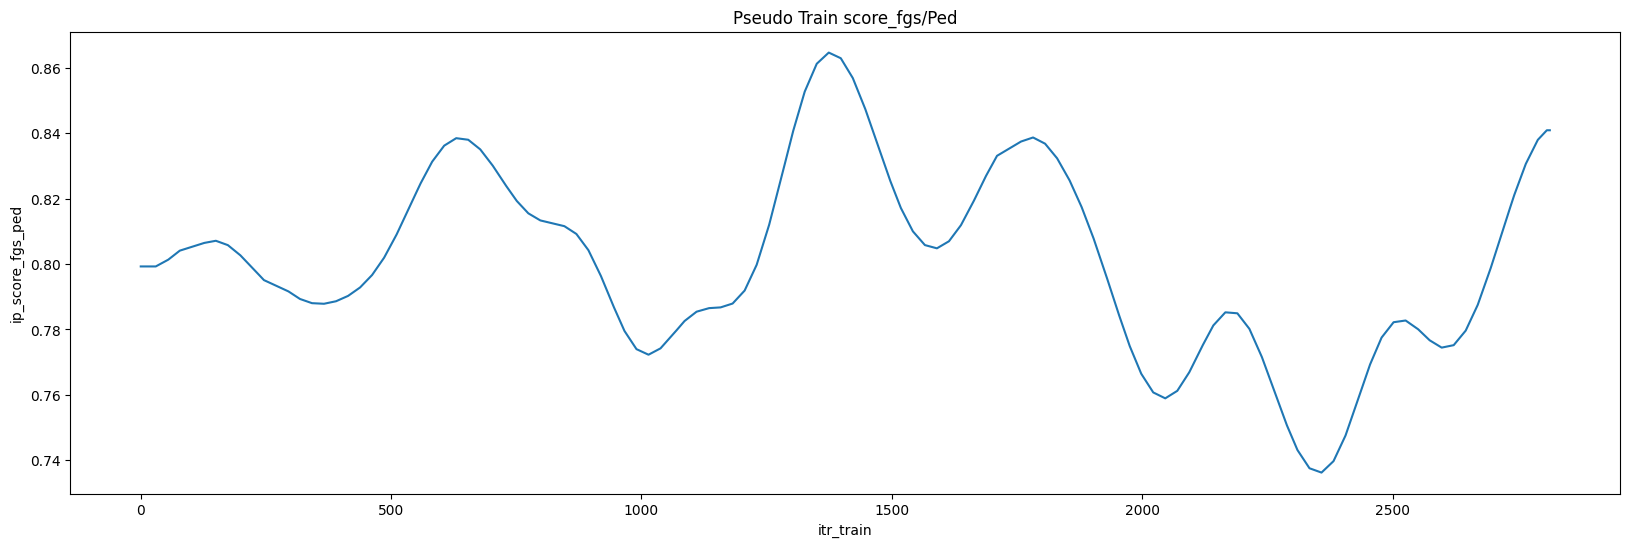

In [7]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=dfw_score_fgs_ped, x="step", y="value",
             ).set_title("Test score_fgs/Ped")

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip, x="itr", y="ip_score_fgs_ped",
             ).set_title("Test smoothened score_fgs/Ped")
             
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip_train, x="itr_train", y="ip_score_fgs_ped",
             ).set_title("Pseudo Train score_fgs/Ped")

3. Cyclist

Text(0.5, 1.0, 'Pseudo Train score_fgs/Cyc')

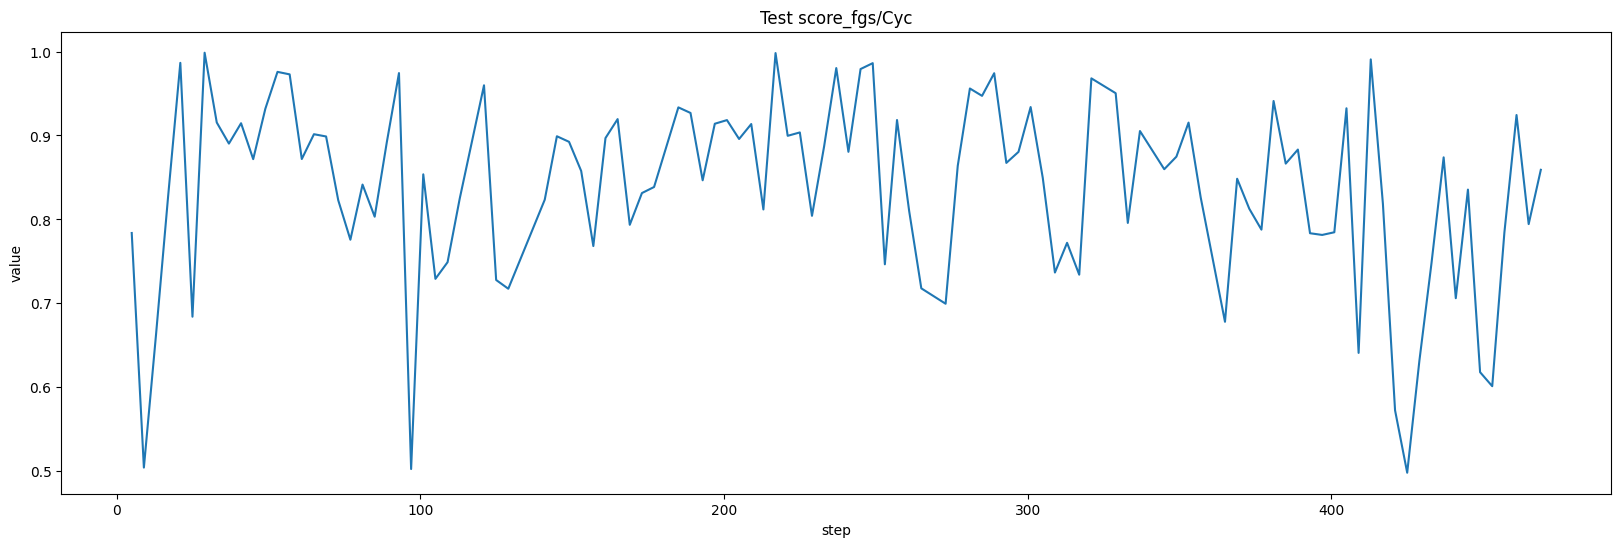

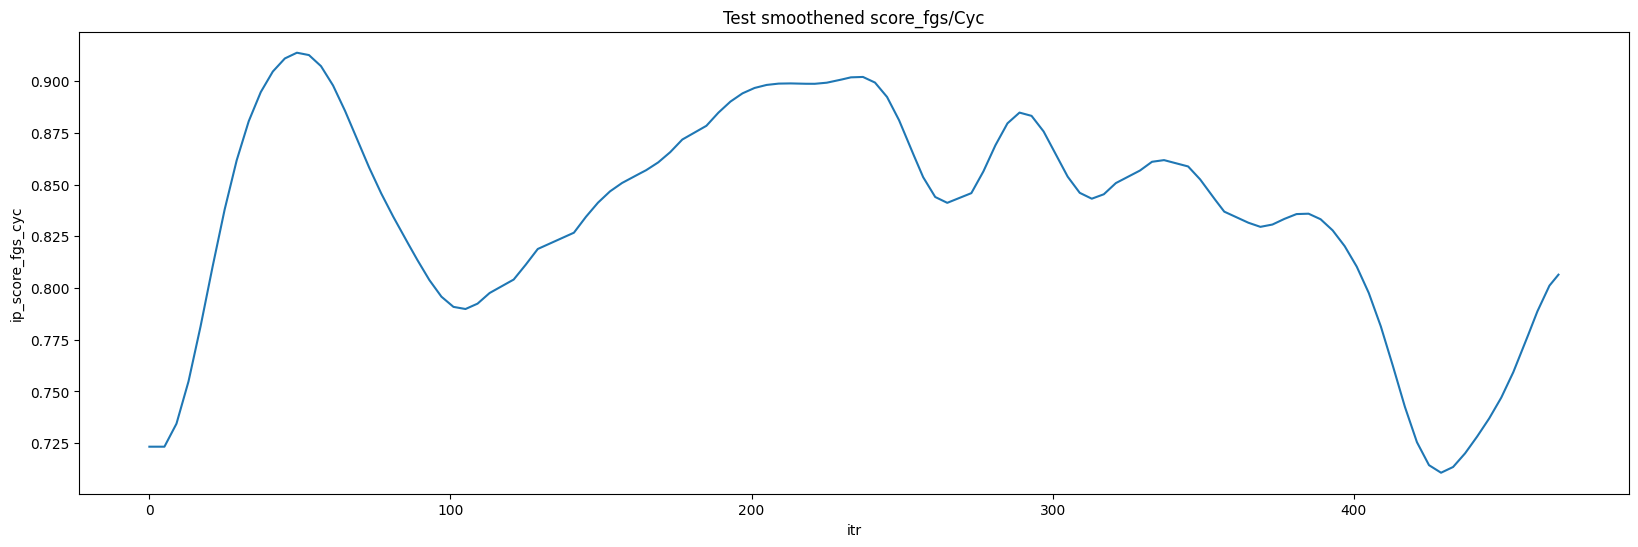

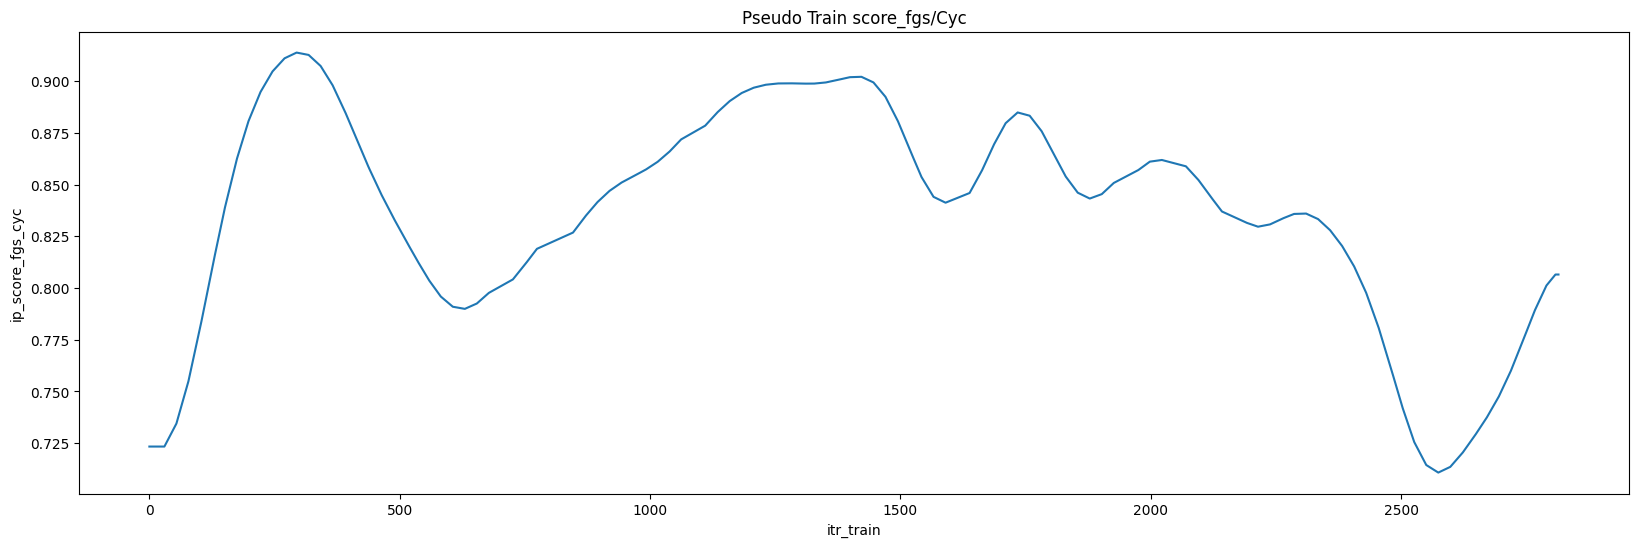

In [8]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=dfw_score_fgs_cyc, x="step", y="value",
             ).set_title("Test score_fgs/Cyc")

plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip, x="itr", y="ip_score_fgs_cyc",
             ).set_title("Test smoothened score_fgs/Cyc")  
             
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_ip_train, x="itr_train", y="ip_score_fgs_cyc",
             ).set_title("Pseudo Train score_fgs/Cyc")  